#### A Recursive Formulation of Repeated Games

**Authors**: Chase Coleman with Thomas Sargent

This notebook describes Julia code that implements an algorithm for computing equilibrium values and associated equilibrium strategy profiles for repeated games with $N$ players and finite actions.

The code builds on ideas of Abreu, Pearce, Stachetti (1986, 1990).

It uses a numerical algorithm called the _outer hyperplane approximation algorithm_ invented  by Judd, Yeltekin, Conklin (2003).

We focus on a particularly simple example, namely, a repeated prisoner's dilemma.

Our friends Timothy Hills and Ben Tengelsen provided useful comments about detailed aspects of  the algorithm.


### Technical Julia Advisory

The quant-econ `GameTheory` library is currently under development and not yet a published Julia package

To get it, please run

    using Pkg
    Pkg.add("https://github.com/QuantEcon/GameTheory.jl")

   
This command may also install some additional packages such as `Clp`, `MathProgBase`, `QuantEcon`, `Polyhedra`, and `CDDLib` (and whatever dependencies these packages rely on).

Plotting in this notebook uses  the package `PlotlyJS`.

A cautionary note: occasionally (but not always) users of this notebook have experienced  difficulty installing `CDDLib` and `Polyhedra` (sometimes due to no fault of their own).

This, the first version of this  notebook, uses  the following versions of various packages:

* `CDDLib` -> v0.1.2
* `Games` -> v0.0.1
* `Polyhedra` -> v0.1.3
* `PlotlyJS` -> v0.5.2

Please verify that you have the correct versions of these packages [1, 2]. 

We have found that occasionally users have struggled to get `CDDLib` to build. 

If this happens to you, make sure that you have [libgmp](https://gmplib.org/) installed.[3] After it has been installed, please run `Pkg.build("CDDLib")`.

If you encounter problems beyond these, please raise an issue about them in the package's repository or in the [QuantEcon.notebooks repository](https://github.com/QuantEcon/QuantEcon.notebooks).

[1] You can do this by creating a dictionary `d = Pkg.installed()` and then looking at version associated with `d["PackageName"]`

[2] You can specify that you'd like to download a particular version of a package with `Pkg.add("PackageName", v"x.y.z")` where `x.y.z` refers to the version number (Note that the `v` is before the quotations on purpose).

[3] On an Ubuntu machine, you can do this with `sudo apt-get install libgmp-dev`


In [1]:
using GameTheory
using PlotlyJS

WebIO._IJuliaInit()

## Introduction

Ideas in play in this notebook are a one-shot or stage **game** and its **Nash equilibria**;  a **repeated game** and the values associated with its **subgame perfect equilibria**; **backward induction** and **dynamic programming**; and **linear programming**

While each of these concepts is worth studying in its own right, here we will focus only on the mechanics necessary to understand the outer approximation algorithm.

### A Game

A *game* consists of
  * a list of players
  * a set of actions available to each player
  * a description of payoffs to each player as a function of actions chosen by all players
  * a timing protocol which specifies who chooses what when


### Nash equilibrium

A *Nash equilibrium* is a collection of actions that pass the following test: the action of each player gives that player the highest payoff, taking as given the actions of all other players.

### A Repeated Game

A *repeated game* in discrete time consists of
  * A game replayed by the same players at a sequence of dates $t =0, 1, \ldots, T$, where $T$ might be infinity
  * A common discount rate at which all players discount future payoffs
  * For each player a *strategy* in the form of a sequence of functions; the time $t$ component of this sequence  prescribes an action at time $t$ as a function of information available to that player at $t$

### Subgame Perfect Equilibria

A *Subgame Perfect equilibrium* is a collection of strategies, one for each player, that satisfies the test that, given other players' strategies, each player wants to adhere to his strategy at each date $t \geq 0$ for all possible histories

A *Subgame Perfect value* is the expected discounted utility that an agent receives within a subgame perfect equilibrium.

### Backwards Induction and Dynamic Programming

We will encounter an operator reminscent of the *Bellman operator* associated with dynamic programming. This new operator, $\mathcal{B}$, maps a **set** of a vector of continuation values into a **set** of a vector of values. The $i$th element of a vector of values is the discounted value assigned to agent $i$. Continuation value vectors are be drawn from a *set* of candidate value vectors.  For good reasons, we will be tempted to iterate to convergence on this operator.  

### Linear programming

We'll use linear programs to do most of the heavy lifting

### Prisoner's Dilemma

We'll use the prisoner's dilemma as an example

## One-Shot Prisoner's Dilemma

The Prisoners' Dilemma is a list of two players and a $2 \times 2$ payoff matrix designed to express the following situation.

Two suspects are in police custody. Without a confession or testimony from one of the suspects, the police have evidence indicating but not proving that together the two committed a serious crime. But the police have enough evidence to convict both suspects on a less serious crime. The police offer both the suspects the following deal: If you betray your partner by testifying against him, then we'll let you walk free while your partner is punished for the serious crime; but if you accuse each other, then we'll convict both of  you of the more serious crime but with a slightly lesser sentence than if you had stayed quiet. The suspects know that the police have only enough evidence to convict them of the lesser charge if neither of them betrays the other.

We represent this game with the following payoff matrix:

<table align="center">
  <tr>
    <td style="border-style:hidden hidden hidden hidden; "> </td>
    <td style="border-style:hidden hidden solid hidden;"> B Silent </td>
    <td style="border-style:hidden hidden solid hidden;"> B Betray </td>
  </tr>
  
  <tr>
    <td style="border-style:hidden solid hidden hidden;"> A Silent </td>
    <td style="color:blue; border-style:solid;"> (9, 9) </td>
    <td style="color:blue; border-style:solid;"> (10, 1) </td>
  </tr>
  
  <tr>
    <td style="border-style:hidden solid hidden hidden;"> A Betray </td>
    <td style="color:blue; border-style:solid;"> (1, 10) </td>
    <td style="color:blue; border-style:solid;"> (3, 3) </td>
  </tr>
</table>

In this game there is a unique Nash equilibrium in which both A and B choose to  betray and receive payoffs (3, 3).

## Repeated Prisoner's Dilemma

We change the game by repeating it forever.

The same two criminals repeatedly face the prisoner's dilemma an infinite number of times. 

They play the game described above in every period with the same per period payoffs. Both players discount the future at $\delta \in (0, 1)$.

In the unique Nash equilibrium of a single shot prisoners dilemma, both players betray.

Do there exist subgame perfect equilibria of the **repeated prisoner's dilemma game** in which the prisoners always remain silent?

If the prisoners are patient enough, i.e.,  $\delta$  is close enough to one,  the answer is **yes**.

In the repeated game, the prisoners' payoffs depend on sequences of both players' actions.

Let $\vec{a}$ ($\vec{b}$) denote the history of actions  of prisoner A (B)  and let $a_t$ ($b_t$) denote the action taken by A (B) at period $t$. 

Then A's present value of payoffs is

$$v^A(\vec{a}, \vec{b}) = (1-\delta) \sum_{t=0}^{\infty} \delta^t u(a_t, b_t)$$

and B's present value of payoffs is

$$v^B(\vec{a}, \vec{b}) = (1-\delta) \sum_{t=0}^{\infty} \delta^t u(b_t, a_t)$$

where

$$u(a_t, b_t) = \begin{cases} 9 \text{ if } a_t = b_t = \text{silent} \\ 10 \text{ if } a_t = \text{betray}  \ \& \ b_t = \text{silent} \\ 1 \text{ if } a_t = \text{silent} \ \&  \ b_t = \text{betray} \\ 3 \text{ if } a_t = b_t = \text{betray} \end{cases}$$

We can now use the QuantEcon `Games` library to represent the stage game and the repeated game.

The stage game is simply created by `NormalFormGame((A, B))`. This command takes a tuple of players (in this case `A` and `B`) and using the information held about payoffs for each player creates a normal form game. For more information consider reviewing the [Tools for Game Theory notebook](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/game_theory_jl.ipynb).

A repeated game is then defined as a normal form game and a discount factor. It is created by the command `RepeatedGame(nfg, delta)`.

In [2]:
# Create the payoff matrix for prisoner's dilemma
pd_payoff = [9.0 1.0
             10.0 3.0]

# Create two players: A and B
A, B = Player(pd_payoff), Player(pd_payoff)

# These two players and their payoffs define a stage game
nfg = NormalFormGame((A, B))

# The repeated game is stage game plus a discount factor
delta = 0.75
rpd = RepeatedGame(nfg, delta)

RepeatedGame{2, Float64}(2×2 NormalFormGame{2, Float64}, 0.75)

### APS Insight

We follow Abreu, Pearce, Stachetti (1986, 1990) (whom we denote APS hereon) who created a set of practical techniques for characterizing all possible subgame equilibrium **values**. 

APS use the following objects and flow of ideas.

  * A history of action pairs $a^t, b^t = (a_0,b_0), (a_1, b_1), \ldots , (a_t,b_t) $

  * A strategy $\sigma^i$ for a player is a time $0$ action and a sequence of functions $\{\sigma_t^i\}_{t=0}^\infty $, the $t$th component of which maps a history $a^{t-1}, b^{t-1}$ into a time $t$ action for player $i$
  
  * A strategy profile $\sigma = (\sigma^A, \sigma^B)$ for our two players.
  
  * The observation that a strategy profile determines a pair of present discounted values $(v^A, v^B)$ for our two players (just plug the implied sequence of action pairs into the appropriate  expressions for discounted utility).

  * A definition of **subgame equilibria** as strategy profiles that satisfy the requirement that given the other player's strategy, each player wants to adhere to his  strategy at each date $t \geq 0$ for all possible histories.
  
  * The observation that a strategy consists of a first-period action and a (continuation) strategy to be followed subsequently.
  
  * The observation that continuation strategy profiles have associated present values
$\tilde{v}^A, \tilde{v}^B$ too.
  
  * The observation that a subgame equilibrium consists of first period actions for both players chosen in light of players' (rational) expectations about the consequences of those choices for future utilities.
  
  * A characterization of subgame equilibrium values $v^i, i= A, B$ in terms of a first period action pair $a^A, a^B$ and a pair of subgame perfect continuation values $\tilde v^i, \check v^i$  that satisfy recursions $$v^i = (1-\delta) u(a^i, a^{-i}) + \delta \tilde v^i   \geq (1- \delta ) u( \check a^i, a^{-i} ) + \delta \check v^i \quad (\dagger)$$ where $a^i$ is the action chosen by player $i$ and $a^{-i}$ is the action chosen by player $-i$ (the other player). Here $\tilde v^i$ is the continuation value that player $i$ receives if he adheres to a strategy that prescribes first period action $a^i$ this period and $\check v^i$ is the continuation value in a subgame perfect equilibrium value prescribed if the player deviates from the strategy by choosing $\check a^i \neq a^i$.

 APS note that

  * Equation $(\dagger)$ for each player $i$ maps **pairs** of subgame perfect equilibrium continuation values $\tilde v^i, \check v^i$ into a single value $v^i$.

  * Equation $(\dagger)$ characterizes **all** subgame perfect equilibrium values. This means that $\tilde v^i$ and $\check v^i$ each satisfy versions of this equation where they are now on the **left** side of the equation and another pair of continuation values are on the right side. That $\check v^i$ is itself a subgame perfect equilibrium value captures the notion that it is the value associated with a strategy that is a **credible threat** that deters player $i$ from deviating from the first-period action $a^i$.

  * APS use this insight together with the backward induction inherent in equation ($\dagger$) to characterize the set of subgame perfect equilibrium values $V \in \mathbb{R}^2$ as the largest fixed point of iterations of a set-to-set mapping $\mathcal{B}$ that maps four-tuples of continuation values, two for player $A$, two for player $B$, into pairs of values, one for player $A$ and one for player $B$.
  
More formally, let $W \subseteq \mathbb{R}^2$ be a compact set of pairs of candidate continuation values: one for player $A$ and the other for player $B$.

A reward is a continuation value that a player receives for adhering to a strategy; a punishment is a continuation value that a player receives for deviating from a strategy.

To be a subgame equilibrium stategy, both the reward and the punishment must be values associated with (possibly other) subgame perfect equilibrium strategies.

APS's aim is to find the set of value pairs associated with _all_ subgame equilibrium 
strategy profiles.

In the spirit of dynamic programming, APS start by guessing a set of candidate continuation values to use as rewards and punishments and then deducing the set of values that those continuation values could support in the sense of satisfying a counterpart to
the incentive constraint equation ($\dagger$). Their proposal is to iterate on this construction.

Thus, APS's $\mathcal{B}$ operator maps a set of candidate pairs of continuation values $W$ into the set of values that can be supported by using elements of $W$ as rewards and punishments for players $A$ and $B$. In particular, one can consider without loss of generality a particular pair of punishments, the worst-case punishments, $(\underline{w}_1, \underline{w}_2)$ where

\begin{align*}
\underline{w}_i &= \min_{w_i} \; w_i \\
                 &\text{subject to } w_i \in W
\end{align*}

To understand why we can use only the worst-cast punishments, $(\underline{w}_1, \underline{w}_2)$, just look at equation ($\dagger$). If the inequality is satisfied for some ($\tilde{v}_i$, $\check{v}_i$) then it is also satisfied for ($\tilde{v}_i, \underline{w}_i$) because $\check{v}_i \geq \underline{w}_i$.

Using the insight that we can consider only worst-case punishments, the $\mathcal{B}$ operator is explicitly defined by

\begin{align*}
  \mathcal{B}(W) &= \{ (w_1, w_2) \\
  &\text{such that} \\
  &(w_1, w_2) \in W \\
  &\exists (a_1, a_2) \text{ such that } \forall \check{a}_1 \;(1-\delta) u(a_1, a_2) + \delta w_1 \geq (1- \delta) u(\check{a}_1, a_2) + \delta \underline{w}_1 \\
  &\exists (a_1, a_2) \text{ such that } \forall \check{a}_2 \;((1-\delta) u(a_1, a_2) + \delta w_2 \geq (1- \delta) u(a_1, \check{a}_2) + \delta \underline{w}_2 \}
\end{align*}

  * APS show that $\mathcal{B}$ is a **monotone operator** in the sense that if $V \subset V'$ then $\mathcal{B}(V) \subset \mathcal{B}(V')$

  * The monotonicity of $\mathcal{B}$ means that 
    - iterations on $\mathcal{B}$ starting from any initial set converge to a fixed point.
    - if we start from a sufficiently large initial guess $W_0$, iterations on $\mathcal{B}$ converge to the largest fixed point.
    - It can then be verified that the largest fixed point of $\mathcal{B}$ equals the set of all subgame equilibrium values.

To make things work, it is important to start APS's operator $\mathcal{B}$ from a generous (meaning it might be too big) set of candidate continuation values $W$.  From this set, the algorithm draws  two pairs $\tilde v^i, \check v^i$ for $i=A, B$, where $\tilde v^i, \check v^i$ are both drawn from the $i$ component of W (usually, $\tilde v^i$ a high value and $\check v^i$ a low value) for $i=A,B$.  It then finds a feasible first period 
action pair and associated pair of values $v^A, v^B$ that satisfies inequalities $(\dagger)$. The set of **all** value pairs $v^A, v^B$ that satisfy these inequalities for 
a given set of candidate continuation values is a new set $\mathcal{B}(W)$.  


#### Public Randomization

Judd, Yeltekin, Conklin (2003) simplify a candidate value set by *convexifying* it.  This can be accomplished  with **public randomization**

Public randomization enables players to coordinate by making their actions depend on a commonly observed public signal. For example: At the beginning of every period every player observes a realization of a uniform random variable with domain on the interval $[0,1]$. If the realization is less than 0.5, then the players take some previously agreed upon action while if the number is greater than 0.5 then they each take a (possibly different) previously specified action. This device ensures the convexity of value sets. If players can achieve $V = (v_1, v_2)$ and $W = (w_1, w_2)$, then  public randomization lets players achieve any value $Z = \lambda V + (1-\lambda) W$.

In line with our example, one can think of  $\lambda$ as a probability of an event that leads players to choose  SPE actions with  value $V$, while the complement of $\lambda$ is an event that prompts  SPE actions with value $W$.

We have left out many technical details here, but if you are interested in understanding this material further then we recommend reading Abreu Pearce Stacchetti 1986, Abreu Pearce Stachetti 1990, and Judd Yeltekin Conklin 2003 (all are cited at the end of this notebook).


### Approximating the set

A key recommendation of JYC 2003 is a way to approximate the set of subgame perfect equilibrium values. 

As mentioned above, we use public randomization to assure that sets are convex.

A convenient property of convex sets (polytopes in particular) is that  because we only need to keep track of extreme points, they can be represented easily inside a computer. This is referred to as the vertice representation.

It is also useful to recognize that polytopes could also be represented as the intersection of a finite number of half-spaces.

The algorithm will mostly represent sets in the half-space representation, but we mention the vertice representation because that is typically how we envision (and display) sets.

We can describe a set using half-spaces in the following way: Consider a set of subgradients (think about these as directional vectors) $H$. For example, let $H = \{ (1, 0), (0, 1), (-1, 0), (0, -1) \}$. Let $C$ be a set of hyperplane levels, for example,  $C = \{4, 3, 2, 1\}$. The halfspace corresponding to a specific subgradient, $h \in H$, and hyperplane level, $c \in C$, is described by the set $s = \{ (x, y) | h \cdot (x, y) \leq c \}$. In our example, the set of half-spaces would be $S = \{s_1, s_2, s_3, s_4\}$, where

\begin{align*}
  s_1 &:= \{ (x, y) | x \leq 4 \} \\
  s_2 &:= \{ (x, y) | y \leq 3 \} \\
  s_3 &:= \{ (x, y) | -x \leq 2 \} \\
  s_4 &:= \{ (x, y) | -y \leq 1 \}
\end{align*}

We draw the following below:

  * Each of the half-spaces (draw their hyper-planes)
  * Intersection of the half-spaces (shaded red)
  * Subgradients ($h_i$)

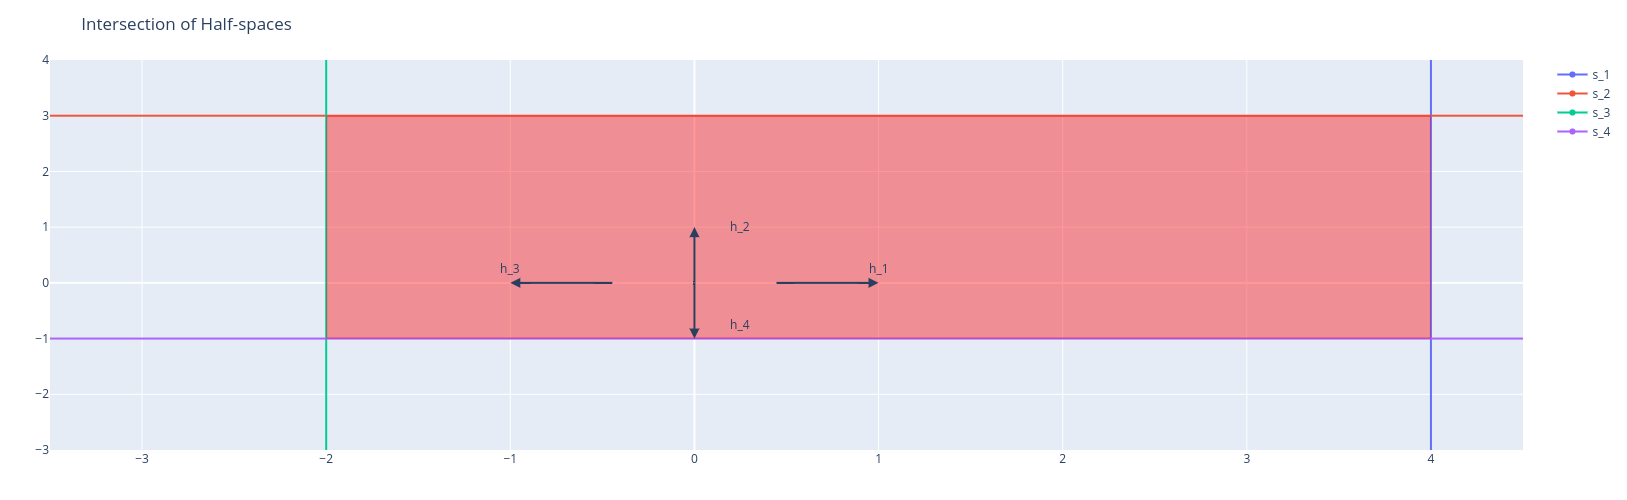

In [5]:
n = 2
ls_m5_p5 = range(-5, stop=5, length=n)

# Build traces
t_s1 = scatter(;x=fill(4, n), y=ls_m5_p5, name="s_1")
t_s2 = scatter(;x=ls_m5_p5, y=fill(3, n), name="s_2")
t_s3 = scatter(;x=fill(-2, n), y=ls_m5_p5, name="s_3")
t_s4 = scatter(;x=ls_m5_p5, y=fill(-1, n), name="s_4")

# Build layout
h_s1 = Dict("x"=>1, "y"=>0,"arrowhead"=>2, "arrowsize"=>1, "arrowwidth"=>2,
            "showarrow"=>true, "ax"=>-105, "ay"=>0)
h_s2 = Dict("x"=>0, "y"=>1,"arrowhead"=>2, "arrowsize"=>1, "arrowwidth"=>2,
            "showarrow"=>true, "ax"=>0, "ay"=>65)
h_s3 = Dict("x"=>-1, "y"=>0,"arrowhead"=>2, "arrowsize"=>1, "arrowwidth"=>2,
            "showarrow"=>true, "ax"=>105, "ay"=>0)
h_s4 = Dict("x"=>0, "y"=>-1,"arrowhead"=>2, "arrowsize"=>1, "arrowwidth"=>2,
            "showarrow"=>true, "ax"=>0, "ay"=>-65)

h_1 = Dict("x"=>1, "y"=>0.25,"arrowhead"=>2, "text"=>"h_1", "showarrow"=>false)
h_2 = Dict("x"=>0.25, "y"=>1,"arrowhead"=>2, "text"=>"h_2", "showarrow"=>false)
h_3 = Dict("x"=>-1, "y"=>0.25,"arrowhead"=>2, "text"=>"h_3", "showarrow"=>false)
h_4 = Dict("x"=>0.25, "y"=>-0.75,"arrowhead"=>2, "text"=>"h_4", "showarrow"=>false)

shapes = [rect(-2, 4, -1, 3, fillcolor="red", opacity=0.4, line_width=0)]
l = Layout(;shapes=shapes, title="Intersection of Half-spaces",
            xaxis_range=[-3.5, 4.5], yaxis_range=[-3.0, 4.0],
            annotations=[h_s1, h_s2, h_s3, h_s4,
                         h_1, h_2, h_3, h_4],
            autosize=false, width=700, height=500)

plot([t_s1, t_s2, t_s3, t_s4], l)

We promised to show you three things:
  * Each of the half-spaces
  * Intersection of the half-spaces
  * Subgradients

We have delivered on these promises by plotting the subgradients (directional vectors) as black arrows, plotting the hyperplane of each half space, and shading the intersection of the 4 half-spaces in red. The blue line corresponds to the hyperplane for the first half-space and everything to the left of this line is an element of the half-space. The orange line corresponds to the hyperplane for the second half-space and everything below this line is an element of the half-space. The green line corresponds to the hyperplane for the third half-space and everything to the right of this line is an element of the half-space. The red line corresponds to the hyperplane for the fourth half-space and everything above this line is an element of the half-space.

This picture also provides insights into  relationships among the subgradient, hyperplane level, and the hyperplane/half-space. In particular, note that the hyperplane of the half-space is orthogonal to its corresponding subgradient -- The subgradient determines the slope and orientation of the set (whether it lies to the left, right, above, or below the hyperplane). The hyperplane level determines the location of the hyperplane -- It expresses how far from the origin the hyperplane lies. We will see this highlighted again when we plot value sets associated with the repeated game.

In practice how do we map our $\mathcal{B}$ operator into the correct set of half-spaces?

We accomplish this by transforming the $\mathcal{B}$ operator into a sequence of linear programs that constructs the smallest convex set that contains the fixed point of the $\mathcal{B}$ operator.  We call this smallest convex set the **outer hyperplane approximation**.

Here is an outline of the **outer hyperalogrithm**.

1. Initialize elements of our algorithm
  * Subgradients, $H$
  * Hyperplane levels, $C$
2. Given a  set of subgradients and  corresponding hyperplane levels
  * For each subgradient, $h \in H$,
    1. Solve a linear program for each action in the action space
    2. Find maximum to update hyperplane level
    3. Find the associated $(w_1, w_2)$ pair
3. Check whether hyperplane levels changed more than the set tolerance. If so, return to 2. Else, proceed.
4. Set of vertices is described by $Z$ and define $W^* = \text{co}(Z)$.

We discuss each of these steps in more detail below

### Step 1: Initilization Step

#### Unit Circle

There is not a unique way to pick the initial subgradients and hyperplane levels. However, a way that seems to work quite well is simply to  partition a unit circle. If there are $N$ subgradients, set

$$h_i = \left( \cos \left( 2 \pi \frac{i}{N} \right), \sin \left(2 \pi \frac{i}{N} \right) \right)$$

Here is a function that produces such a set of subgradients. We plot them below.

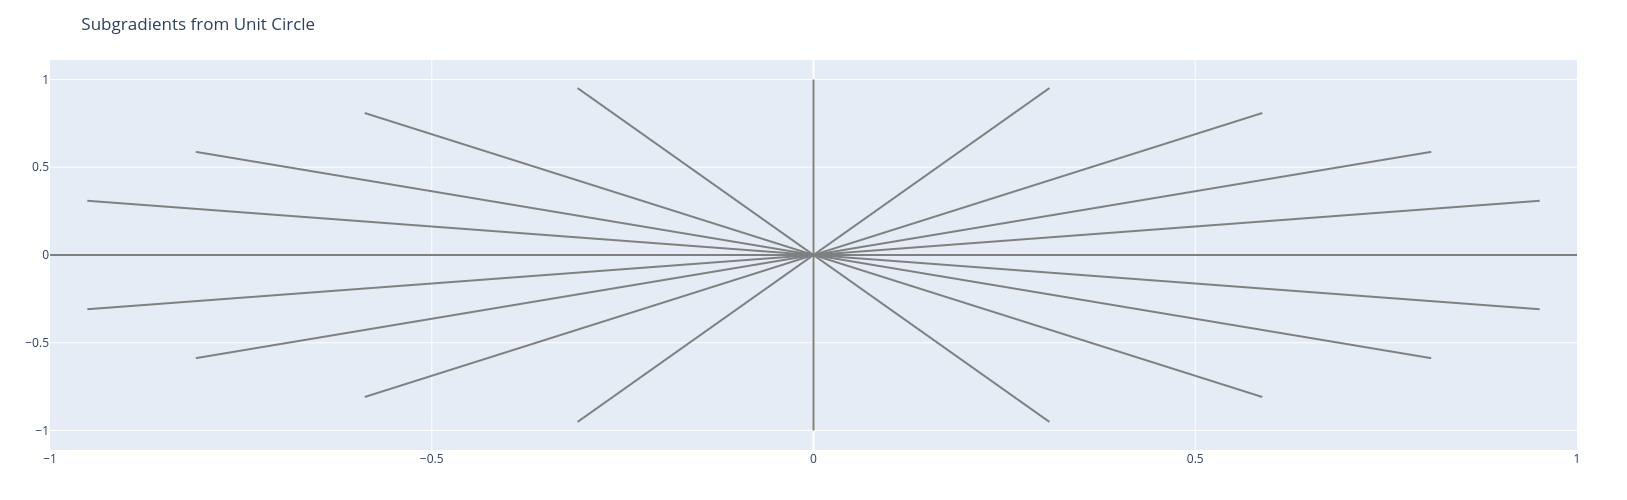

In [7]:
n = 20
pts = GameTheory.unitcircle(n)
p = plot(scatter(), Layout(;title="Subgradients from Unit Circle",
                            autosize=false, height=500, width=700))

for i=1:n
    xi, yi = pts[i, :]
    ti = scatter(;x=[0.0, xi], y=[0.0, yi], mode="lines",
                  name="Subgradient $i", line_color="grey",
                  showlegend=false)
    addtraces!(p, ti)
end

p

Here there are $n$ lines. Each line is a single subgradient. Try to conceive a half-space at the end of each of these subgradients -- Points that determine the shape of the polygon aren't actually the points at the end of the subgradients, but rather  points at which the halfspaces intersect. As we drive the  number of lines to infinity, we will obtain a circle.

#### Hyperplanes

In addition to choosing the subgradient directions, we must also pick initial hyperplane levels. One way (again this isn't unique) is to pick an origin and a radius, then to compute points that would be along the circle in the direction of each subgradient. Once we have these points then we can use them to compute the hyperplane levels simply by $H \cdot Z'$.

<!-- Recall that continuation payoffs are $\sum \delta^t (1-\delta) u(a_t, b_t)$. If a player receives his worst (or best) utility  every period, then that is his discounted value. Therefore, values are bounded above by a player's maximum possible payoff and bounded below by a player's minimum possible payoff. It is infeasible for a player to receive a value smaller (or bigger) than this, and so, using our circle as a starting point, we can crop the size of this set along those values. We use this information (though it isn't necessary) in the function that generates an initial set for our iteration process. This set has to be "big enough," but the bigger the set is the longer it takes to compute the equilibrium value set. There is a tradeoff between ensuring that our set is big enough and saving computation time.

Notice how the points are no longer forumlated around the unit circle, but instead are now a (cropped as described above) circle of radius 10 around (4.5, 4.5).

Notice that we had a very large radius in this picture, so the code trimmed it down to a rectangle along the minimum and maximum payoffs that the players can each have.
-->


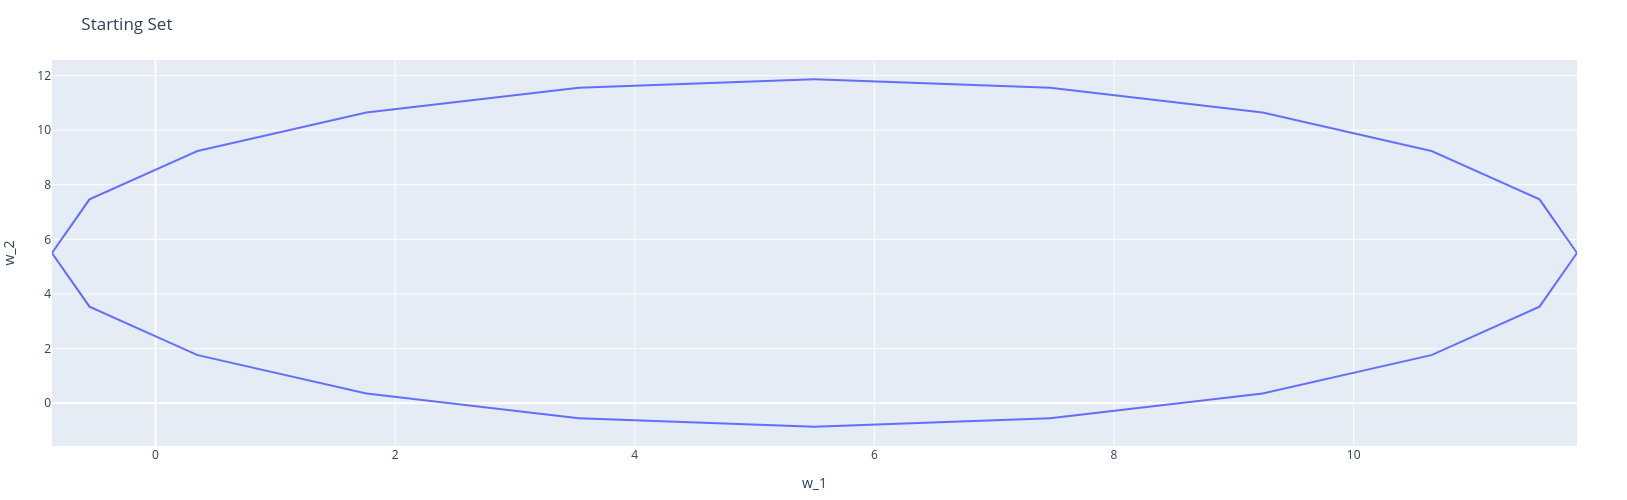

In [8]:
n = 20
C, H, Z = GameTheory.initialize_sg_hpl(rpd, n)
t = scatter(;x=vcat(Z'[:, 1], Z[1, 1]), y=vcat(Z'[:, 2], Z[2, 1]))
l = Layout(;title="Starting Set", xaxis_title="w_1", yaxis_title="w_2",
            autosize=false, height=500, width=700)
p = plot(t, l)

### Step 2: Iterative Step

The general idea of this step will be to push each hyperplane (which defines the set's boundary) as far in each direction as possible -- We are trying to make the set of continuation values as large as possible while satisfying the constraints of the $\mathcal{B}$ operator.

There is a sequence of linear programs (one for each subgradient) that each take the following form. For the current subgradient $h_i$ and given a specified action for today, $a$, maximize the dot product of the agents' values and the subgradient (i.e. maximize in a specific direction):

\begin{align*}
  \max_{w} \; &h_i \cdot ((1-\delta) u(a) + \delta w) \\
  &\text{subject to} \\
  &(w_1, w_2) \in W \\
  &(1-\delta) u_1(a) + \delta w_1 \geq (1-\delta) u_1(a_{-1}) + \delta \underline{w}_1 \\
  &(1-\delta) u_2(a) + \delta w_2 \geq (1-\delta) u_2(a_{-2}) + \delta \underline{w}_2
\end{align*}

The three constraints just correspond to the constraints described in our $\mathcal{B}$ operator. The first specifies that we are picking continuation values from the set $W$ and the next two insure that the continuation values are incentive compatible given the specified action.

In order to apply the standard linear programming routines, we need to change this problem into the form

\begin{align*}
  \min_x \; & c^T x \\
  &\text{subject to } \\
  &Ax \leq b
\end{align*}

The following observations guide us.

1) $\max_w h_i \cdot ((1-\delta) u(a) + \delta w)$ produces the same optimal solution, $w^*$, as $\min_w -h_i \cdot ((1-\delta) u(a) + \delta w)$.

2) Additionally, $\min_w h_i \cdot (u(a) + \delta w)$ produces the same optimal solution, $w^*$, as $\min_w h_i \cdot \delta w$.

3) $w \in W$ is equivalent to $H \cdot w \leq C$ (where $C$ are our hyperplane levels and $H$ are our subgradients).

4) $(1-\delta) u_i(a) + \delta w_i \geq (1-\delta) u^*_i(a_{-i}) + \delta \underline{w}_i$ can be rewritten as $-\delta w_i \leq (1-\delta) (u_i(a) - u^*_i(a_{-i})) - \delta \underline{w}_i$.

Using these observations, we now specify the values for $c, x, A, b$ that relate the standard linear programming description to our specific linear program.

* Variable we maximize over is $x = \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}$
* The objective vector will be $c^T = \begin{bmatrix} -h_1 & -h_2 \end{bmatrix}$
* $A$ and $b$ are then made up of combinations of the matrices and vectors from the constraints. Let $N$ be the number of subgradients used in the approximation, let $h^n_i$ denote the $i$th element of the $n$th subgradient (i.e. $H_{n, i}$), and let $c_i$ denote the $i$th element of the hyperplane level vector (i.e. $C_i$) then:
  - $A = \begin{bmatrix} h^1_1 & h^1_2 \\ h^2_1 & h^2_2 \\ \dots \\ h^N_1 & h^N_2 \\ -\delta & 0 \\ 0 & -\delta \end{bmatrix}$
  - $b = \begin{bmatrix} c_1 \\ c_2 \\ \dots \\ c_N \\ (1-\delta) (u_1(a) - u^*_1(a_{-1})) - \delta \underline{w}_1 \\ (1-\delta) (u_2(a) - u^*_2(a_{-2})) - \delta \underline{w}_2 \end{bmatrix}$.
  - It is important to note that the vector $b$ depends on $a$ -- This means that the vector $b$ will change as we iterate over different actions. The dependence of $c^T$ on $h_i$ implies that it will also change as we iterate over the different subgradients.

The functions which implement the details of these steps can be found in the [Games.jl](https://github.com/QuantEcon/Games.jl) library. Applying these steps repeatedly is the basis for the outer hyperplane approximation theorem we have been discussing. We can see the output of this below.

In [9]:
pd_payoff = [9.0 1.0
             10.0 3.0]

A = Player(pd_payoff)
B = Player(pd_payoff)

pd = NormalFormGame((A, B))
rpd = RepeatedGame(pd, 0.75)

RepeatedGame{2, Float64}(2×2 NormalFormGame{2, Float64}, 0.75)

We now call the `outerapproximation` function that applies our algorithm. We include the `verbose=true` argument in order to watch the algorithm converge.

In the printouts below, the left entry records the absolute changes in the hyperplane levels $C$ and $C'$ -- Evidently, the longer we iterate, the closer the two sets of hyperplane levels become. The right entry records a tuple $(\underline{w}_1, \underline{w}_2)$ -- As the set shrinks, these objects grow monotonically larger. That can be interpreted as occurring because the potential punishments available become weaker as we iterate.

In [10]:
hp_pts = outerapproximation(rpd; nH=64, maxiter=500, tol=1e-8,
                            verbose=true, nskipprint=10);

10	0.08865814883358247	(2.709875698216042, 2.7098756982160457)
20	0.004992651968453998	(2.9836620808639114, 2.983662080863915)
30	0.0002811537800653241	(2.9990799543504063, 2.9990799543504094)
40	1.583275753080926e-5	(2.9999481889957753, 2.999948188995779)
50	8.915982236956665e-7	(2.9999970823402498, 2.999997082340252)
60	5.809012115776113e-8	(2.999999835696323, 2.999999835696326)


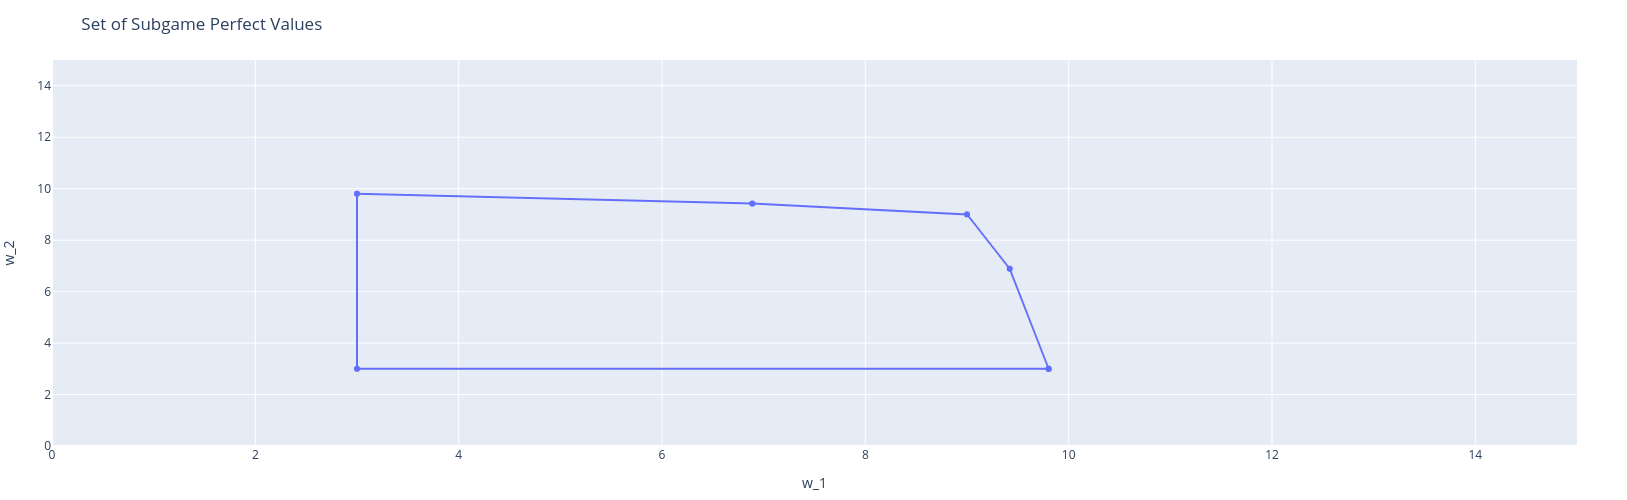

In [11]:
# Add the first point to the bottom as well so that
# the polygon connects
plot_pts = vcat(hp_pts, hp_pts[1, :]')

plot(scatter(;x=plot_pts[:, 1], y=plot_pts[:, 2], mode="lines+markers"),
     Layout(;xaxis_range=[0, 15], yaxis_range=[0, 15],
             title="Set of Subgame Perfect Values",
             xaxis_title="w_1", yaxis_title="w_2",
             autosize=false, height=500, width=700))

The approximation of the set of subgame perfect equilibrium values are presented above.

There are several things to take note of:
  * The criminals can sustain silence (The (9, 9) payoff is an element of the set)
  * One of the criminals could possibly do better than the silence payoff though the other would do worse.
  * The worst case punishments in this case correspond to the Nash equilibrium -- This is not always the case. Sometimes lower payoffs can be sustained.

We could think about varying the discount factor. How would this change the set of achievable values?

In [12]:
pd_payoff = [9.0 1.0
             10.0 3.0]

A = Player(pd_payoff)
B = Player(pd_payoff)

pd = NormalFormGame((A, B))
rpd1 = RepeatedGame(pd, 0.9)
rpd2 = RepeatedGame(pd, 0.2475)

hp_pts1 = outerapproximation(rpd1; nH=128, maxiter=750, tol=1e-8);
hp_pts2 = outerapproximation(rpd2; nH=128, maxiter=750, tol=1e-8);

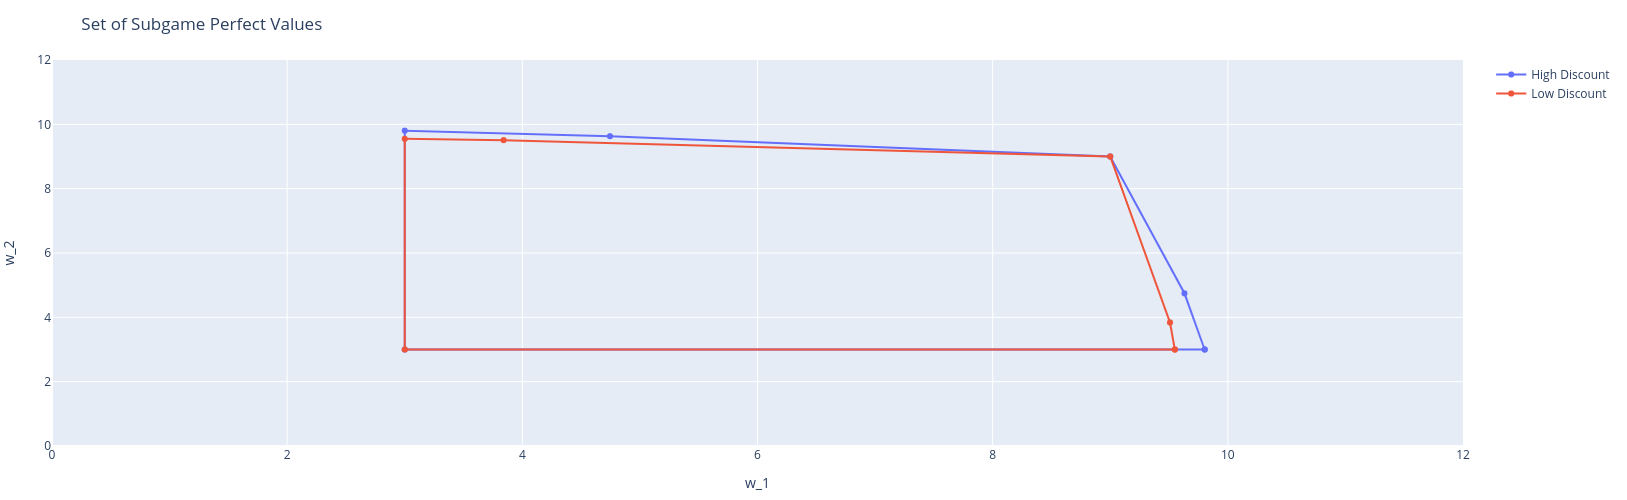

In [13]:
pts_1 = vcat(hp_pts1, hp_pts1[1, :]')
t1 = scatter(;x=pts_1[:, 1], y=pts_1[:, 2], mode="lines+markers", name="High Discount")
pts_2 = vcat(hp_pts2, hp_pts2[1, :]')
t2 = scatter(;x=pts_2[:, 1], y=pts_2[:, 2], mode="lines+markers", name="Low Discount")

plot([t1, t2],
     Layout(;xaxis_range=[0, 12], yaxis_range=[0, 12],
             title="Set of Subgame Perfect Values",
             xaxis_title="w_1", yaxis_title="w_2",
             autosize=false, height=500, width=700))

While the differences themselves are pretty small, it does appear that high discount factor supports a slightly larger set of equilibrium though (which isn't surprising).

### Deducing SPE strategies

In addition to wanting SPE values, we also want strategy profiles that attain them. Some of these  are obvious -- For example, (9, 9) is sustained by maintaining silence and (3, 3) is sustained by always betraying. Others are less obvious and involve  mixtures of silence and betrayal.

Here is how APS would deduce a SPE equilbrium strategy profile associated with a SPE value profile $v\in V$.

Let $s \in U[0,1]$ be the uniform random variable used to effect public randomization and let
$V$ be the set of SPE values. 

Start with two $v$s that are extreme points of the final outer hyperplane approximation.  
Let $v_1 = (1-\delta) u(a_1) + \delta v_1'$ and for let $v_2 = (1-\delta) u(a_2) + \delta v_2'$ be two such SPE values with associated first period actions and continuation value pairs $(a_1, v_1')$, $(a_2,v_2')$, respectively.  Because $v_1$ and $v_2$ are values obtained as extreme points from the outer hyperplane approximation, they use no public randomization. The linear programming algorithm that produces the outer hyperplane approximation  computes pairs $(a_1, v_1')$, $(a_2,v_2')$ that attain these $v$'s.

Now we activate public randomization.

For probability $p \in [0,1]$, we  obtain a continuation value profile  $v \in V$ from 
an appropriate version of the equality

$$ v = p [ (1-\delta) u(a_1) + \delta v_1'] + (1-p) [ (1-\delta) u(a_2) + \delta v_2'] $$

The value profile  $v$ is then attained by a strategy profile that can be represented recursively with the pair of functions

$$ a = f (v,s) $$

$$ v' = g( v, a, s) $$

where $s \in [0,1]$ is a realization of the public random variable.

If we iterate these functions starting from a SPE value profile $v_0 \in V$, we obtain a sequence of functions representing a SPE strategy profile that attains $v_0$:

$$ a_0 = \tilde f_0(a_0, s_0, v_0) $$

$$ a_t = \tilde f_t (a^{t-1}, s^t, v_0) , \quad t \geq 1 $$

Here $s^t $ denotes the history $s_t, s_{t-1}, \ldots, s_0$ and $a^{t-1}$
denotes the history $a_{t-1}, \ldots, a_0$. 




#### References

Abreu, Dilip, David Pearce, and Ennio Stacchetti, 1986. Optimal Cartel Equilibria with Imperfect Monitoring, _Journal of Economic Theory_, 39, 251-269.

Abreu, Dilip, David Pearce, and Ennio Stacchetti, 1990. Toward a Theory of Discounted Repeated Games with Imperfect Monitoring, _Econometrica_, 58, 1041-1063.

Judd,Kenneth, Sevin Yeltekin, and James Conklin, 2003. Computing Supergame Equilibria, _Econometrica_,  71(4), pages 1239-1254, 07.

